Text(0, 0.5, 'y')

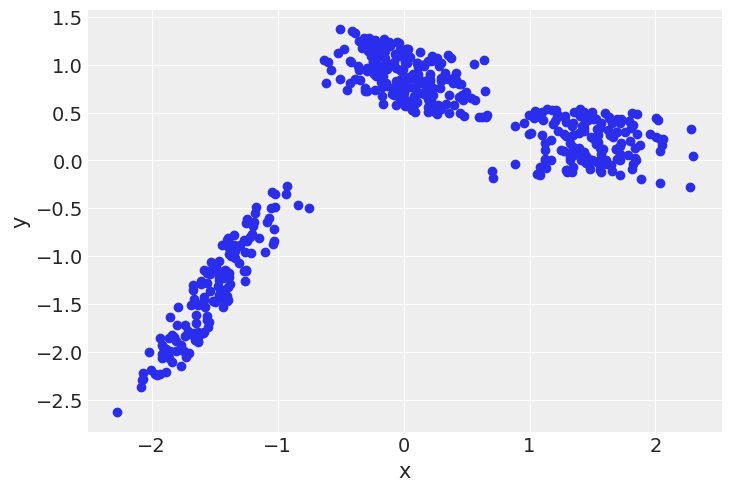

In [17]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
dummy_data = np.loadtxt('date_500.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 5

x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [18]:
# 1 a)
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('ε', 5)
    miu = alpha + beta * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=miu, sigma=sigma, observed=y_1s)
    idata_l = pm.sample(2000, return_inferencedata=True)

with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    sigma = pm.HalfNormal('ε', 5)
    miu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=miu, sigma=sigma, observed=y_1s)
    idata_p = pm.sample(2000, return_inferencedata=True)


# 1 b)
with pm.Model() as model_p_wide:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=order)
    sigma = pm.HalfNormal('ε', 5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_1s)
    idata_p_wide = pm.sample(2000, return_inferencedata=True)

sd_vec = np.array([10, 0.1, 0.1, 0.1, 0.1])

with pm.Model() as model_p_shrink:
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=sd_vec, shape=order)
    sigma = pm.HalfNormal('ε', order)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_1s)
    idata_p_shrink = pm.sample(2000, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, ε]


Output()

/Users/stefaniancu/Documents/An 3 Seminare/PMP/PMP-2025/.venv/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


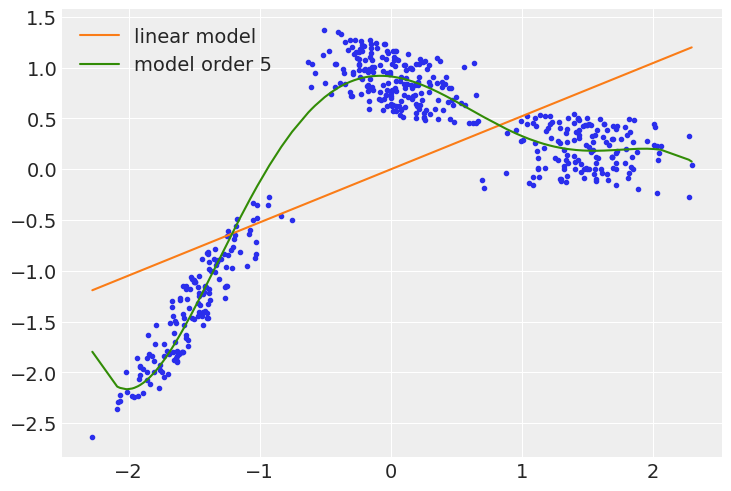

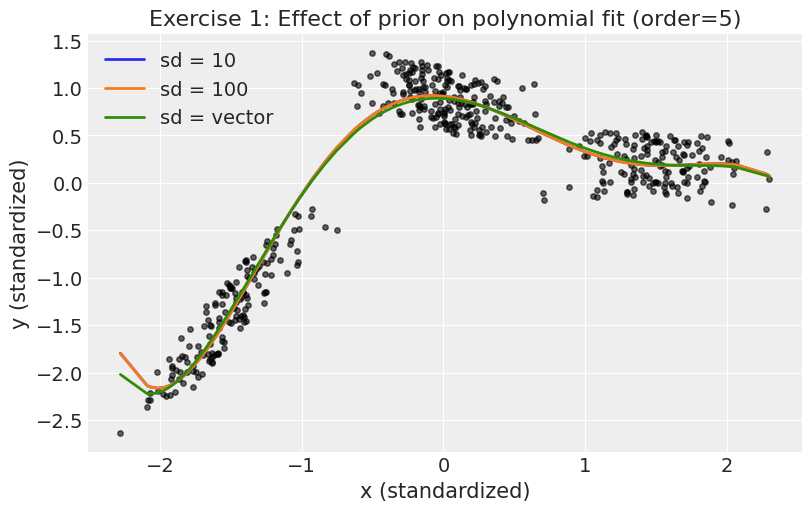

In [19]:
def posterior_curve(idata, x_basis):
    alpha = idata.posterior['alpha'].mean(("chain", "draw")).values
    beta = idata.posterior['beta'].mean(("chain", "draw")).values
    return alpha + np.dot(beta, x_basis)


x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
alpha_l_post = idata_l.posterior['alpha'].mean(("chain", "draw")).values
beta_l_post = idata_l.posterior['beta'].mean(("chain", "draw")).values
y_l_post =alpha_l_post + beta_l_post * x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

alpha_p_post = idata_p.posterior['alpha'].mean(("chain", "draw")).values
beta_p_post = idata_p.posterior['beta'].mean(("chain", "draw")).values
idx = np.argsort(x_1s[0])
y_p_post = alpha_p_post + np.dot(beta_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

plt.figure(figsize=(8, 5))

idx = np.argsort(x_1s[0])

# sd = 10
y_sd10 = posterior_curve(idata_p, x_1s)
plt.plot(x_1s[0][idx], y_sd10[idx], label='sd = 10', lw=2)

# sd = 100
y_sd100 = posterior_curve(idata_p_wide, x_1s)
plt.plot(x_1s[0][idx], y_sd100[idx], label='sd = 100', lw=2)

# heterogeneous sd
y_shrink = posterior_curve(idata_p_shrink, x_1s)
plt.plot(x_1s[0][idx], y_shrink[idx], label='sd = vector', lw=2)

# data
plt.scatter(x_1s[0], y_1s, c='black', s=15, alpha=0.6)

plt.xlabel("x (standardized)")
plt.ylabel("y (standardized)")
plt.title("Exercise 1: Effect of prior on polynomial fit (order=5)")
plt.legend()
plt.show()



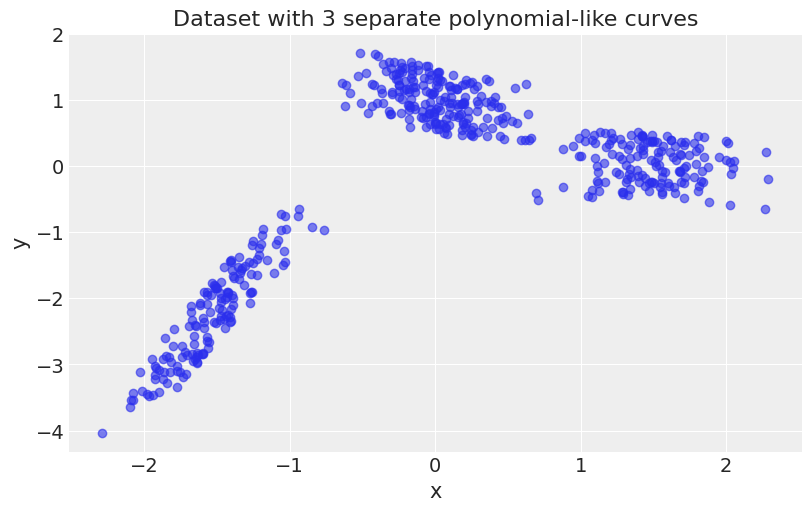

In [20]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_total = 500
n_clusters = 3  # 3 separate curves

# Number of points per cluster
cluster_sizes = [150, 200, 150]

# Cluster centers for x
x_centers = [-1.5, 0, 1.5]

# Different polynomials for each cluster
polynomials = [
    [0.5, 1.0, -0.5],  # cluster 1: y = 0.5 + 1*x - 0.5*x^2
    [1.0, -0.5, 0.2],  # cluster 2
    [-0.5, 0.8, -0.3]  # cluster 3
]

x_list = []
y_list = []

for c, s, coeffs in zip(x_centers, cluster_sizes, polynomials):
    # Generate x around cluster center
    x = np.random.normal(loc=c, scale=0.3, size=s)
    # Compute polynomial y = a + b*x + c*x^2
    y = coeffs[0] + coeffs[1]*x + coeffs[2]*x**2
    # Add some noise
    y += np.random.uniform(-0.5, 0.5, size=s)
    
    x_list.append(x)
    y_list.append(y)

# Combine all clusters
x_total = np.hstack(x_list)
y_total = np.hstack(y_list)

# Shuffle points
indices = np.arange(len(x_total))
np.random.shuffle(indices)
x_total = x_total[indices]
y_total = y_total[indices]

# Save
np.savetxt("date_500.csv", np.column_stack([x_total, y_total]))

# Plot to visualize
plt.figure(figsize=(8,5))
plt.scatter(x_total, y_total, alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Dataset with 3 separate polynomial-like curves")
plt.show()
